In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from matplotlib import gridspec

In [2]:
data_X = np.load('/home/linggel/neuroscience/spike_train.npy')
train_start_idx = 210
train_num_idx = 25
training = data_X[:, :, train_start_idx:(train_start_idx + train_num_idx)]
target = np.load('/home/linggel/neuroscience/odor_target.npy')

In [3]:
print(training.shape)

(194, 54, 25)


In [4]:
training = (training - np.mean(training)) / np.std(training)

In [5]:
lfp_data = np.load('/home/linggel/neuroscience/all_raw_lfp_data.npy')

In [6]:
lfp_data_lowres = lfp_data[:, :, ::10] # downsampling
lfp_training = lfp_data_lowres[:, :, train_start_idx:(train_start_idx + train_num_idx)]

In [7]:
trial_info = np.load('/home/linggel/neuroscience/all_trial_info.npy')
select = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1)

In [8]:
lfp_training = lfp_training[select, : ,:]
print(lfp_training.shape)

(194, 15, 25)


In [9]:
lfp_tetrode = [19, 4, 21, 20, 8, 9, 16, 1, 2, 23, 22, 7, 13, 14, 15]

In [10]:
tetrode_neuron = {1:4, 2:1, 4:1, 7:2, 8:4, 9:1, 13:4, 14:4, 15:5, 16:3, 19:9, 20:2, 21:6, 22:4, 23:4}

In [11]:
all_tetrode_data = []
i = 0
for t in sorted(lfp_tetrode):
    print('Current tetrode {}'.format(t))
    j = lfp_tetrode.index(t)
    tetrode_lfp = lfp_training[:, j, :].reshape((194, 1, 25))
    k = tetrode_neuron[t]
    print('{} neuron/units'.format(k))
    tetrode_spike = training[:, i:(i + k), :].reshape((194, k, 25))
    tetrode_data = np.concatenate([tetrode_lfp, tetrode_spike], axis=1)
    tetrode_data = np.expand_dims(tetrode_data, axis=1)
    print(tetrode_data.shape)
    all_tetrode_data.append(tetrode_data)
    i += k

Current tetrode 1
4 neuron/units
(194, 1, 5, 25)
Current tetrode 2
1 neuron/units
(194, 1, 2, 25)
Current tetrode 4
1 neuron/units
(194, 1, 2, 25)
Current tetrode 7
2 neuron/units
(194, 1, 3, 25)
Current tetrode 8
4 neuron/units
(194, 1, 5, 25)
Current tetrode 9
1 neuron/units
(194, 1, 2, 25)
Current tetrode 13
4 neuron/units
(194, 1, 5, 25)
Current tetrode 14
4 neuron/units
(194, 1, 5, 25)
Current tetrode 15
5 neuron/units
(194, 1, 6, 25)
Current tetrode 16
3 neuron/units
(194, 1, 4, 25)
Current tetrode 19
9 neuron/units
(194, 1, 10, 25)
Current tetrode 20
2 neuron/units
(194, 1, 3, 25)
Current tetrode 21
6 neuron/units
(194, 1, 7, 25)
Current tetrode 22
4 neuron/units
(194, 1, 5, 25)
Current tetrode 23
4 neuron/units
(194, 1, 5, 25)


In [12]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, merge
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2, activity_l2
from keras.utils import np_utils

Using Theano backend.


In [15]:
input_layers = []
for t in sorted(lfp_tetrode):
    k = tetrode_neuron[t]
    input_layers.append(Input(shape=(1, k + 1, 25)))

In [16]:
convolution_layers = []
for i, input_layer in enumerate(input_layers):
    t = sorted(lfp_tetrode)[i]
    k = tetrode_neuron[t]
    convolution_layers.append(Convolution2D(5, k + 1, 1, activation='relu')(input_layer))

In [17]:
combo = merge(convolution_layers, mode='concat', concat_axis=1)

In [18]:
pooling = AveragePooling2D(pool_size=(1, 25))(combo)

In [19]:
x = Flatten()(pooling)
x = Dense(10, activation='relu')(x)
x = Dropout(p=0.1)(x)
prediction = Dense(5, activation='softmax')(x)

In [20]:
model = Model(input_layers, prediction)

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 5, 25)      0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1, 2, 25)      0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1, 2, 25)      0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1, 3, 25)      0                                            
___________________________________________________________________________________________

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
import keras

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_acc'))

In [25]:
hist = LossHistory()
model.fit(all_tetrode_data, target, nb_epoch=400, batch_size=64, verbose=0,
            validation_split=0.1, shuffle=True, callbacks=[hist])

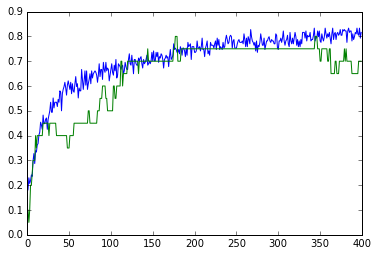

In [26]:
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.plot(hist.losses)
plt.plot(hist.val_losses)
plt.show()

In [20]:
from keras.utils.visualize_util import plot
plot(model, to_file='/home/linggel/spike_train/tetrode_model.png')

In [27]:
def build_model():
    input_layers = []
    for t in sorted(lfp_tetrode):
        k = tetrode_neuron[t]
        input_layers.append(Input(shape=(1, k + 1, 25)))
    convolution_layers = []
    for i, input_layer in enumerate(input_layers):
        t = sorted(lfp_tetrode)[i]
        k = tetrode_neuron[t]
        convolution_layers.append(Convolution2D(5, k + 1, 1, activation='relu')(input_layer))
    combo = merge(convolution_layers, mode='concat', concat_axis=1)
    pooling = AveragePooling2D(pool_size=(1, 25))(combo)
    x = Flatten()(pooling)
    x = Dense(10, activation='relu')(x)
    x = Dropout(p=0.1)(x)
    prediction = Dense(5, activation='softmax')(x)
    model = Model(input_layers, prediction)
    return(model)

In [28]:
from sklearn.cross_validation import KFold, StratifiedKFold

In [29]:
def select_data(index):
    select_data = []
    for x in all_tetrode_data:
        select_data.append(x[index, :, :, :])
    return(select_data)

In [30]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [31]:
kf = StratifiedKFold(target.argmax(axis=-1), n_folds=10)
overall_acc = 0
y_total = np.zeros(target.shape)
y_hat_total = np.zeros(target.shape)
i = 0
for train_index, test_index in kf:
    X_train, X_test = select_data(train_index), select_data(test_index)
    y_train, y_test = target[train_index, :], target[test_index, :]
    model = build_model()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    hist = LossHistory()
    checkpointer = ModelCheckpoint('/home/linggel/neuroscience/current_model.h5', verbose=0, save_best_only=True)
    model.fit(X_train, y_train, nb_epoch=400, batch_size=64, 
              validation_data=(X_test, y_test), 
              callbacks=[hist, checkpointer], verbose=0)
    accuracy = max(hist.val_losses)
    print('Current fold accuracy: {acc}'.format(acc=accuracy))
    overall_acc += accuracy
    best_model = load_model('/home/linggel/neuroscience/current_model.h5')
    y_hat = best_model.predict(X_test)
    n_k = y_hat.shape[0]
    y_total[i:(i + n_k), :] = y_test
    y_hat_total[i:(i + n_k), :] = y_hat
    i += n_k
print(overall_acc / 10.0)

Current fold accuracy: 0.636363625526
Current fold accuracy: 0.523809552193
Current fold accuracy: 0.699999988079
Current fold accuracy: 0.649999976158
Current fold accuracy: 0.699999988079
Current fold accuracy: 0.649999976158
Current fold accuracy: 0.789473712444
Current fold accuracy: 0.833333313465
Current fold accuracy: 0.823529422283
Current fold accuracy: 0.647058844566
0.695356839895


In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
matrix = confusion_matrix(y_total.argmax(axis=-1), y_hat_total.argmax(axis=-1))
print(matrix)

[[54  2  0  0  2]
 [ 2 33  3  3  0]
 [ 2  4 19 11  1]
 [ 2  3 13 12  2]
 [ 3  2 14  3  4]]


In [34]:
import itertools

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

Normalized confusion matrix
[[ 0.93103448  0.03448276  0.          0.          0.03448276]
 [ 0.04878049  0.80487805  0.07317073  0.07317073  0.        ]
 [ 0.05405405  0.10810811  0.51351351  0.2972973   0.02702703]
 [ 0.0625      0.09375     0.40625     0.375       0.0625    ]
 [ 0.11538462  0.07692308  0.53846154  0.11538462  0.15384615]]


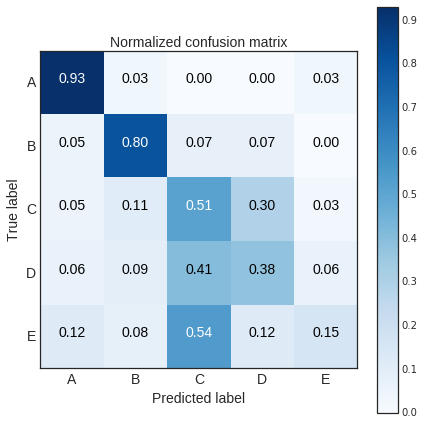

In [46]:
fig = plt.figure(figsize=(6, 6))
#plt.style.use('seaborn-white')
plot_confusion_matrix(matrix, classes=['A', 'B', 'C', 'D', 'E'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
def window_data(spike_data, lfp_data, window_size, stride):
    n_trial, n_neuron, n_timebin = spike_data.shape
    n_channel = lfp_data.shape[1]
    n_example = (n_timebin - window_size) / stride
    window_spike_data = np.zeros((n_trial, n_example, n_neuron, window_size))
    window_lfp_data = np.zeros((n_trial, n_example, n_channel, window_size))
    for i in range(n_example):
        window_start = i * stride
        window_end = i * stride + window_size
        window_spike_data[:, i, :, :] = spike_data[:, :, window_start:window_end]
    return(test_data)

In [111]:
from utils import stack_test_data

In [139]:
print(data_X.shape)

(194, 54, 425)


In [140]:
spike = (data_X - np.mean(training)) / np.std(training)

In [141]:
spike_stack = stack_test_data(spike, 25, 10)

In [142]:
print(spike_stack.shape)

(194, 40, 54, 25)


In [143]:
print(lfp_data_lowres.shape)

(248, 15, 425)


In [144]:
lfp_data = lfp_data_lowres[select, :, :]
print(lfp_data.shape)

(194, 15, 425)


In [145]:
lfp_stack = stack_test_data(lfp_data, 25, 10)

In [146]:
print(lfp_stack.shape)

(194, 40, 15, 25)


In [149]:
def tetrode_data(spike_data, lfp_data):
    all_tetrode_data = []
    i = 0
    for t in sorted(lfp_tetrode):
        #print('Current tetrode {}'.format(t))
        j = lfp_tetrode.index(t)
        tetrode_lfp = lfp_data[:, j, :].reshape((194, 1, 25))
        k = tetrode_neuron[t]
        #print('{} neuron/units'.format(k))
        tetrode_spike = spike_data[:, i:(i + k), :].reshape((194, k, 25))
        tetrode_data = np.concatenate([tetrode_lfp, tetrode_spike], axis=1)
        tetrode_data = np.expand_dims(tetrode_data, axis=1)
        #print(tetrode_data.shape)
        all_tetrode_data.append(tetrode_data)
        i += k
    return(all_tetrode_data)

In [150]:
test_data = tetrode_data(spike_stack[:, 0, :, :], lfp_stack[:, 0, :, :])

In [151]:
pred = model.predict(test_data)

In [152]:
print(pred.shape)

(194, 5)


In [194]:
all_pred = np.zeros((194, 40, 5))

In [195]:
for i in range(40):
    test_data = tetrode_data(spike_stack[:, i, :, :], lfp_stack[:, i, :, :])
    pred = model.predict(test_data)
    all_pred[:, i, :] = pred

In [206]:
def plot_by_odor(odor_index, all_pred, target):
    """Plot predictions for all trials of the same odor.
    
    Args:
        odor_index: (int) odor by which to group
        all_pred: 3d numpy array of format [trial, time, odor]
        target: 2d numpy array of format [trial, odor]
    """
    odor_names = ['A', 'B', 'C', 'D', 'E']
    pred_by_odor = all_pred[(target[:, odor_index] == 1), :, :]
    n_trial = pred_by_odor.shape[0]
    fig = plt.figure(figsize=(20, 3), dpi=200)
    for j in range(5):
        ax = plt.subplot(int('15' + str(j + 1)))
        plt.xticks([9.5, 19.5, 29.5], ['-1s', '0s', '1s'])
        plt.ylim(0, 1)
        rect1 = patches.Rectangle((21, 0), 2.5, 1, linewidth=1, edgecolor='none', facecolor='red', alpha=0.2)
        ax.add_patch(rect1)
        ax.text(5, 0.75, r'$P({})$'.format(odor_names[j]), fontsize=14)
        for i in range(n_trial):
            plt.plot(pred_by_odor[i, :, j], color='black', alpha=0.1)
    plt.suptitle('True odor ' + odor_names[odor_index], fontsize=14, fontweight='bold')
    plt.show()

In [200]:
import matplotlib.patches as patches

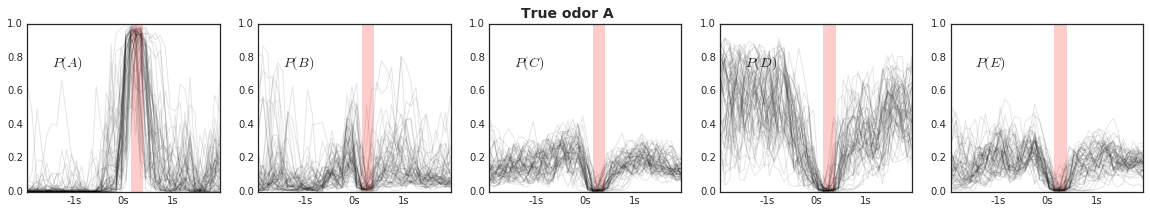

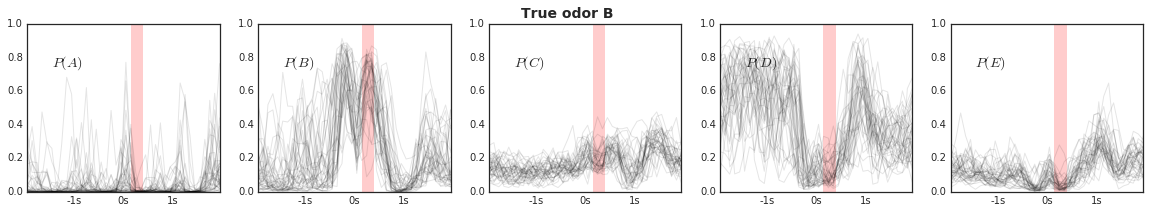

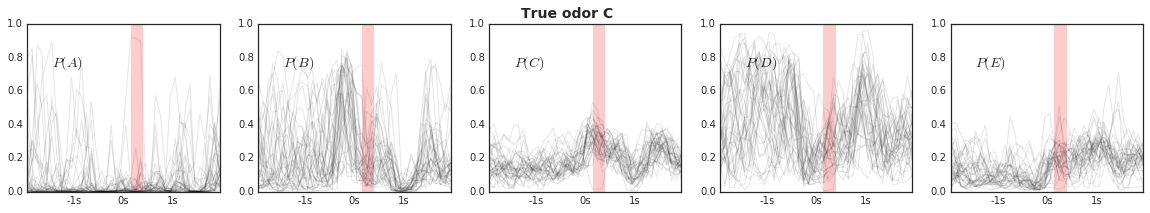

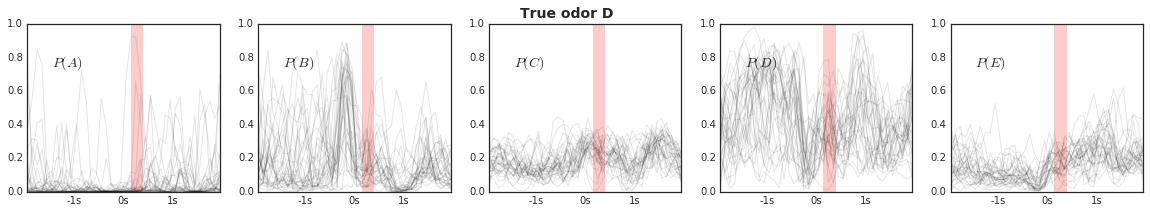

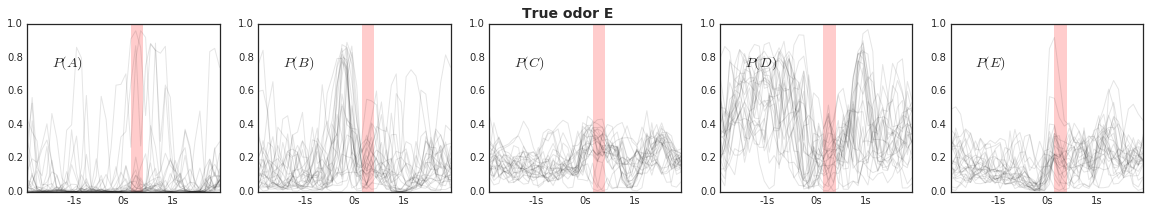

In [207]:
plot_by_odor(0, all_pred, target)
plot_by_odor(1, all_pred, target)
plot_by_odor(2, all_pred, target)
plot_by_odor(3, all_pred, target)
plot_by_odor(4, all_pred, target)